Predict if a patient with diabetes will be readmitted to the hospital within 30 days. 

# Patients Readmission Prediction(Diabetes)

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [73]:
# load the csv file
df = pd.read_csv('diabetic_data.csv')

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [75]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


There is some missing data that are represented with ?. We will deal with this in the feature engineering section. 

The most important column here is `readmitted`, which tells us if a patient was hospitalized within 30 days, greater than 30 days or not readmitted. 

In [76]:
# count the number of rows for each type
df.groupby('readmitted').size()

readmitted
<30    11357
>30    35545
NO     54864
dtype: int64

Another column that is important is `discharge_disposition_id`, which tells us where the patient went after the hospitalization.

In [77]:
df.groupby('discharge_disposition_id').size()

discharge_disposition_id
1     60234
2      2128
3     13954
4       815
5      1184
6     12902
7       623
8       108
9        21
10        6
11     1642
12        3
13      399
14      372
15       63
16       11
17       14
18     3691
19        8
20        2
22     1993
23      412
24       48
25      989
27        5
28      139
dtype: int64

 If we look at the IDs_mapping.csv we can see that 11,13,14,19,20,21 are related to death or hospice. We should remove these samples from the predictive model. 

In [78]:
df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

Now let's define an output variable for our binary classification. Here we will try to predict if a patient is likely to be re-admitted within 30 days of discharge.

In [79]:
df['OUTPUT_LABEL'] = (df.readmitted == '<30').astype('int')

Let's define a function to calculate the prevalence of population that is readmitted with 30 days. 

In [80]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

In [81]:
print('Prevalence:%.3f'%calc_prevalence(df['OUTPUT_LABEL'].values))

Prevalence:0.114


Around 11% of the population is rehospitalized. This represented an imbalanced classification problem so we will address that below. 

Now we would like to get a feeling of the data for each column in our dataset. Pandas doesn't allow you to see all the columns at once, so let's look at them in groups of 10. 

In [82]:
print('Number of columns:',len(df.columns))

Number of columns: 51


In [83]:
df[list(df.columns)[:10]].head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1


In [84]:
df[list(df.columns)[10:20]].head()

,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2
0,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?
1,?,?,59,0,18,0,0,0,276,250.01
2,?,?,11,5,13,2,0,1,648,250
3,?,?,44,1,16,0,0,0,8,250.43
4,?,?,51,0,8,0,0,0,197,157


In [85]:
df[list(df.columns)[20:30]].head()

,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide
0,?,1,NaN,NaN,No,No,No,No,No,No
1,255,9,NaN,NaN,No,No,No,No,No,No
2,V27,6,NaN,NaN,No,No,No,No,No,No
3,403,7,NaN,NaN,No,No,No,No,No,No
4,250,5,NaN,NaN,No,No,No,No,No,No


In [86]:
df[list(df.columns)[30:40]].head()

,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide
0,No,No,No,No,No,No,No,No,No,No
1,No,No,No,No,No,No,No,No,No,No
2,Steady,No,No,No,No,No,No,No,No,No
3,No,No,No,No,No,No,No,No,No,No
4,Steady,No,No,No,No,No,No,No,No,No


In [87]:
df[list(df.columns)[40:]].head()

,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,OUTPUT_LABEL
0,No,No,No,No,No,No,No,No,No,NO,0
1,No,Up,No,No,No,No,No,Ch,Yes,>30,0
2,No,No,No,No,No,No,No,No,Yes,NO,0
3,No,Up,No,No,No,No,No,Ch,Yes,NO,0
4,No,Steady,No,No,No,No,No,Ch,Yes,NO,0


From this, we see that there are a lot of categorical (non-numeric) variables. Note that the variables with _id are also categorical and you can see what the ids refer to with the IDs_mapping.csv. Let's take a look at the unique values for each column. 

In [88]:
# for each column
for c in list(df.columns):
    
    # get a list of unique values
    n = df[c].unique()
    
    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(n)<30:
        print(c)
        print(n)
    else:
        print(c + ': ' +str(len(n)) + ' unique values')

encounter_id: 99343 unique values
patient_nbr: 69990 unique values
race
['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
gender
['Female' 'Male' 'Unknown/Invalid']
age
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight
['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id
[6 1 2 3 4 5 8 7]
discharge_disposition_id
[25  1  3  6  2  5  7 10  4 18  8 12 16 17 22 23  9 15 24 28 27]
admission_source_id
[ 1  7  2  4  5 20  6  3 17  8  9 14 10 22 11 25 13]
time_in_hospital
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
payer_code
['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty: 73 unique values
num_lab_procedures: 118 unique values
num_procedures
[0 5 1 6 2 3 4]
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency: 33 unique values
number_inpatient
[ 0  1  2  3  6 

From analysis of the columns, we can see there are a mix of categorical (non-numeric) and numerical data. A few things to point out, 

    - encounter_id and patient_nbr: these are just identifiers and not useful variables
    - age and weight: are categorical in this data set
    - admission_type_id,discharge_disposition_id,admission_source_id: are numerical here, but are IDs (see IDs_mapping). They should be considered categorical. 
    - examide and citoglipton only have 1 value, so we will not use these variables
    - diag1, diag2, diag3 - are categorical and have a lot of values. We will not use these as part of this project, but you could group these ICD codes to reduce the dimension. We will use number_diagnoses to capture some of this information. 
    - medical_speciality - has many categorical variables, so we should consider this when making features. 

# Feature Engineering

In this section, we will create features for our predictive model. For each section, we will add new variables to the dataframe and then keep track of which columns of the dataframe we want to use as part of the predictive model features. We will break down this section into numerical features, categorical features and extra features. 

In this data set, the missing numbers were filled with a question mark. Let's replace it with a nan representation. 

In [89]:
# replace ? with nan
df = df.replace('?',np.nan)

## Numerical Features

The easiest type of features to use is numerical features. These features do not need any modification. The columns that are numerical that we will use are shown below

In [ ]:
columns_num = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

Let's check if there are any missing values in the numerical data. 

In [ ]:
df[columns_num].isnull().sum()

time_in_hospital      0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_outpatient     0
number_emergency      0
number_inpatient      0
number_diagnoses      0
dtype: int64

## Categorical Features

The next type of features we want to create are categorical variables, which represent non-numeric data such as race and gender. To convert this non-numeric data into usable variables, we can use a simple technique called one-hot encoding, which we will explain below. 

The first set of categorical data we will deal with are these columns:

In [ ]:
columns_cat = ['race', 'gender', 
       'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','payer_code']

Let's check if there are any missing data

In [ ]:
df[columns_cat].isnull().sum()

race                         2234
gender                          0
max_glu_serum               94191
A1Cresult                   82509
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
payer_code                  39398
dtype: int64

`race`, `payer_code`, and `medical_specialty` have missing data. Since these are categorical data, the best thing to do is to just add another categorical type for unknown using the `fillna` function. 

In [94]:
df['race'] = df['race'].fillna('UNK')
df['payer_code'] = df['payer_code'].fillna('UNK')
df['medical_specialty'] = df['medical_specialty'].fillna('UNK')

Let's investigate medical specialty before we begin. 

In [95]:
print('Number medical specialty:', df.medical_specialty.nunique())
df.groupby('medical_specialty').size().sort_values(ascending = False)

Number medical specialty: 73


medical_specialty
UNK                                 48616
InternalMedicine                    14237
Emergency/Trauma                     7419
Family/GeneralPractice               7252
Cardiology                           5279
                                    ...  
Psychiatry-Addictive                    1
Speech                                  1
Perinatology                            1
SportsMedicine                          1
Surgery-PlasticwithinHeadandNeck        1
Length: 73, dtype: int64

We can see that most of them are unknown and that the count drops off pretty quickly. We don't want to add 73 new variables since some of them only have a few samples. As an alternative, we can create a new variable that only has 11 options (the top 10 specialities and then an other category). Obviously, there are other options for bucketing, but this is one of the easiest methods. 

In [ ]:
top_10 = ['UNK','InternalMedicine','Emergency/Trauma',\
          'Family/GeneralPractice', 'Cardiology','Surgery-General' ,\
          'Nephrology','Orthopedics',\
          'Orthopedics-Reconstructive','Radiologist']

# make a new column with duplicated data
df['medical_Spec'] = df['medical_specialty'].copy()

# replace all specialties not in top 10 with 'Other' category
df.loc[~df.med_spec.isin(top_10),'medical_Spec'] = 'Other'

In [ ]:
df.groupby('medical_Spec').size()

med_spec
Cardiology                     5279
Emergency/Trauma               7419
Family/GeneralPractice         7252
InternalMedicine              14237
Nephrology                     1539
Orthopedics                    1392
Orthopedics-Reconstructive     1230
Other                          8199
Radiologist                    1121
Surgery-General                3059
UNK                           48616
dtype: int64

To convert our categorical features to numbers, we will use a technique called one-hot encoding. In one-hot encoding, you create a new column for each unique value in that column. Then the value of the column is 1 if the sample has that unique value or 0 otherwise. For example, for the column race, we would create new columns ('race_Caucasian','race_AfricanAmerican', etc). If the patient's race is Caucasian, the patient gets a 1 under 'race_Caucasian' and 0 under the rest of the race columns. To create these one-hot encoding columns, we can use the `get_dummies` function. 

Now the problem is that if we create a column for each unique value, we have correlated columns. In other words, the value in one column can be figured out by looking at the rest of the columns. For example, if the sample is not AfricanAmerican, Asian, Causasian, Hispance or Other, it must be UNK. To deal with this, we can use the `drop_first` option, which will drop the first categorical value for each column. 

The get_dummies function does not work on numerical data. To trick get_dummies, we can convert the numerical data into strings and then it will work properly. 

In [98]:
cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

df[cols_cat_num] = df[cols_cat_num].astype('str')

Now we are ready to make all of our categorical features

In [99]:
df_cat = pd.get_dummies(df[cols_cat + cols_cat_num + ['med_spec']],drop_first = True)

In [100]:
df_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_Norm,A1Cresult_>8,...,med_spec_Emergency/Trauma,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


To add the one-hot encoding columns to the dataframe we can use `concat` function. Make sure to use axis = 1 to indicate add the columns. 

In [101]:
df = pd.concat([df,df_cat], axis = 1)

Save the column names of the categorical data. 

In [102]:
cols_all_cat = list(df_cat.columns)

## Extra features

The last two columns we want to make features are `age` and `weight`. Typically, you would think of these as numerical data, but they are categorical in this dataset as shown below.  

In [103]:
df[['age', 'weight']].head()

,age,weight
0,[0-10),NaN
1,[10-20),NaN
2,[20-30),NaN
3,[30-40),NaN
4,[40-50),NaN


One option could be to create categorical data as shown above. Since there is a natural order to these values, it might make more sense to convert these to numerical data. Another example when you would want to do this might be size of a t-shirt (small, medium, large). Let's start with age. 

In [104]:
df.groupby('age').size()

age
[0-10)        160
[10-20)       690
[20-30)      1649
[30-40)      3764
[40-50)      9607
[50-60)     17060
[60-70)     22059
[70-80)     25331
[80-90)     16434
[90-100)     2589
dtype: int64

Let's map these to 0-9 for the numerical data. 

In [105]:
age_id = {'[0-10)':0, 
          '[10-20)':10, 
          '[20-30)':20, 
          '[30-40)':30, 
          '[40-50)':40, 
          '[50-60)':50,
          '[60-70)':60, 
          '[70-80)':70, 
          '[80-90)':80, 
          '[90-100)':90}
df['age_group'] = df.age.replace(age_id)

C:\Users\setha\AppData\Local\Temp\ipykernel_35468\2384569142.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['age_group'] = df.age.replace(age_id)


Now let's look at weight. Recall that this feature is not filled out very often.  

In [106]:
df.weight.notnull().sum()

np.int64(3125)

Instead of creating an ordinal feature that we did above, let's just create a variable to say if weight was filled out or not. The presence of a variable might be predictive regardless of the value. 

In [107]:
df['has_weight'] = df.weight.notnull().astype('int')

Let's keep track of these extra columns too. 

In [108]:
cols_extra = ['age_group','has_weight']

## Engineering Features Summary

In [109]:
print('Total number of features:', len(cols_num + cols_all_cat + cols_extra))
print('Numerical Features:',len(cols_num))
print('Categorical Features:',len(cols_all_cat))
print('Extra features:',len(cols_extra))

Total number of features: 141
Numerical Features: 8
Categorical Features: 131
Extra features: 2


Let's check if we are missing any data. 

In [110]:
df[cols_num + cols_all_cat + cols_extra].isnull().sum().sort_values(ascending = False).head(10)

time_in_hospital      0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_outpatient     0
number_emergency      0
number_inpatient      0
number_diagnoses      0
race_Asian            0
race_Caucasian        0
dtype: int64

let's make a new dataframe that only has the columns of interest

In [111]:
col2use = cols_num + cols_all_cat + cols_extra
df_data = df[col2use + ['OUTPUT_LABEL']]

# Building Training/Validation/Test Samples

So far we have explored our data and created features from the categorical data. It is now time for us to split our data. The idea behind splitting the data is so that you can measure how well your model would do on unseen data. We split into three parts:
    - Training samples: these samples are used to train the model
    - Validation samples: these samples are held out from the training data and are used to make decisions on how to improve the model
    - Test samples: these samples are held out from all decisions and are used to measure the generalized performance of the model
  
In this project, we will split into 70% train, 15% validation, 15% test. 

The first thing I like to do is to shuffle the samples using `sample` in case there was some order (e.g. all positive samples on top). Here `n` is the number. `random_state` is just specified so the entire class gets the same shuffling. You wouldn't need `random_state` in your own projects. 

In [112]:
# shuffle the samples
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)

We can use `sample` again to extract 30% (using `frac`) of the data to be used for validation / test splits. It is important that validation and test come from similar distributions and this technique is one way to do it. 

In [113]:
# Save 30% of the data as validation and test data 
df_valid_test=df_data.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.300


And now split into test and validation using 50% fraction. 

In [114]:
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

Note that `.drop` just drops the rows from `df_test` to get the rows that were not part of the sample. We can use this same idea to get the training data. 

In [115]:
# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)

At this point, you might say, drop the training data into a predictive model and see the outcome. However, if we do this, it is possible that we will get back a model that is 89% accurate. Great! Good job! But wait, we never catch any of the readmissions (recall= 0%). How can this happen? 

What is happening is that we have an imbalanced dataset where there are much more negatives than positives, so the model might just assigns all samples as negative. 

Typically, it is better to balance the data in some way to give the positives more weight. There are 3 strategies that are typically utilized:
    - sub-sample the more dominant class: use a random subset of the negatives
    - over-sample the imbalanced class: use the same positive samples multiple times
    - create synthetic positive data
    
Usually, you will want to use the latter two methods if you only have a handful of positive cases. Since we have a few thousand positive cases, let's use the sub-sample approach. Here, we will create a balanced training data set that has 50% positive and 50% negative. You can also play with this ratio to see if you can get an improvement. 

In [116]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 15766):0.500


Since we have done a lot of work, let's save our data.

In [117]:
df_train_all.to_csv('df_train_all.csv',index=False)
df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

Most machine learning packages like to use an input matrix X and output vector y, so let's create those:

In [118]:
X_train = df_train[col2use].values
X_train_all = df_train_all[col2use].values
X_valid = df_valid[col2use].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (69540, 141)
Training shapes: (15766, 141) (15766,)
Validation shapes: (14901, 141) (14901,)


Some machine learning models have trouble when the variables are of different size (0-100, vs 0-1000000). To deal with that we can scale the data. Here we will use scikit learn's Standard Scaler  which removes the mean and scales to unit variance. Here I will create a scaler using all the training data, but you could use the balanced one if you wanted. 

In [119]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

StandardScaler()

We will need this scaler for the test data, so let's save it using a package called `pickle`. 

In [120]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [121]:
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

Now we can transform our data matrices 

In [122]:
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

# Model Selection

Wow! so much work to get ready for a model. This is always true in data science. You spend 80-90% cleaning and preparing data. 

In this section, we train a few machine learning models and use a few techniques for optimizing them. We will then select the best model based on performance on the validation set.

We will utilize the following functions to evaluate the performance of the model.

In [123]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

Since we balanced our training data, let's set our threshold at 0.5 to label a predicted sample as positive. 

In [124]:
thresh = 0.5

## Model Selection: baseline models

In this section, we will compare the performance of 7 machine learning models using default hyperparameters. 

### K nearest neighbors (KNN)

In [125]:
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(n_neighbors=100)

In [126]:
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

KNN
Training:
AUC:0.650
accuracy:0.606
recall:0.487
precision:0.638
specificity:0.676
prevalence:0.500
 
Validation:
AUC:0.620
accuracy:0.671
recall:0.466
precision:0.164
specificity:0.659
prevalence:0.113
 


### Logistic regression

In [127]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=42)

In [128]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.678
accuracy:0.628
recall:0.559
precision:0.648
specificity:0.697
prevalence:0.500
 
Validation:
AUC:0.660
accuracy:0.662
recall:0.553
precision:0.179
specificity:0.676
prevalence:0.113
 


### Decision Tree Classifier

In [129]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [130]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.734
accuracy:0.669
recall:0.631
precision:0.683
specificity:0.705
prevalence:0.500
 
Validation:
AUC:0.626
accuracy:0.636
recall:0.574
precision:0.170
specificity:0.641
prevalence:0.113
 


### Random Forest

In [131]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [132]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.692
accuracy:0.639
recall:0.608
precision:0.648
specificity:0.670
prevalence:0.500
 
Validation:
AUC:0.658
accuracy:0.628
recall:0.604
precision:0.173
specificity:0.631
prevalence:0.113
 


## Model Selection: Feature Importance

One path for improving your models to understand what features are important to your models. This can usually only be investigated for simpler models such as Logistic Regression or Random Forests. This analysis can help in a few areas:
    
    - inspire new feature ideas --> helps with both high bias and high variance
    - obtain a list of the top features to be used for feature reduction --> helps with high variance
    - point out errors in your pipeline --> helps with robustness of model

Let's get the feature importance for a few models and then we can discuss what we see. 


### Feature Importance: Logistic regression

Logistic regression is a very interpretable model because the coefficient for each variable shows how important that variable is for the prediction. Note that you need to have normalized the data so the coefficients are comparable between variables. We can extract the coefficients using `coef_` and store in a new dataframe (sorted by importance) 

In [133]:
feature_importances = pd.DataFrame(lr.coef_[0],
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [134]:
feature_importances.head()

,importance
number_inpatient,0.358934
rosiglitazone_No,0.266170
rosiglitazone_Steady,0.221364
discharge_disposition_id_22,0.202573
repaglinide_No,0.177308


For logistic regression, the variables with highest positive coefficients are predictive of re-hospitalization and the variables with highest negative coefficients are predictive of not being re-hospitalized. We can plot the top 50 for each direction below. 

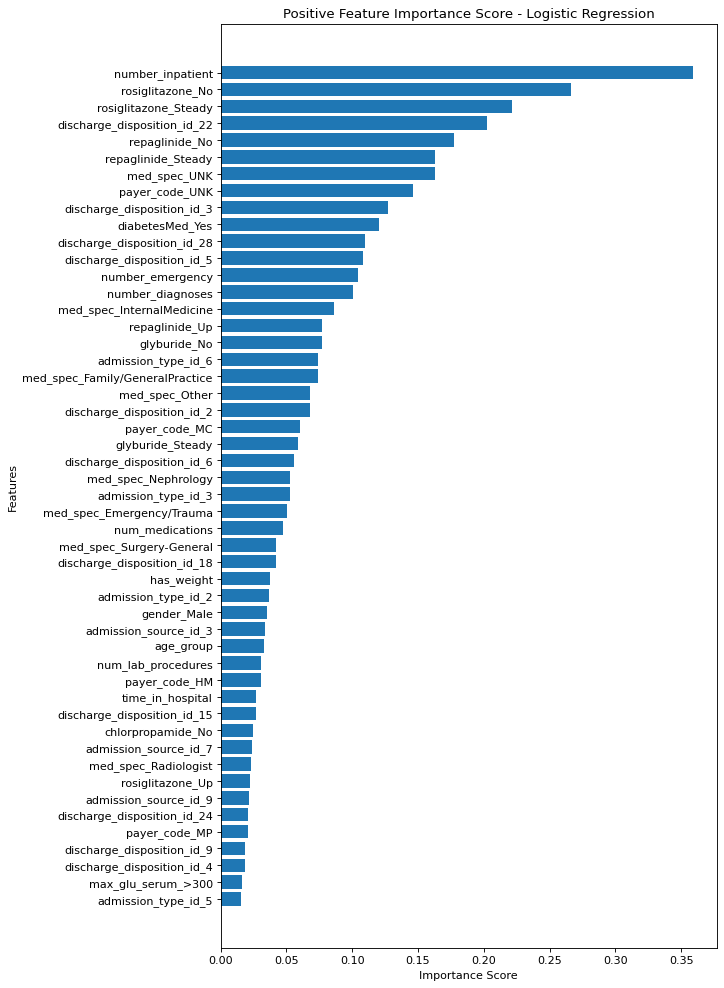

In [135]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

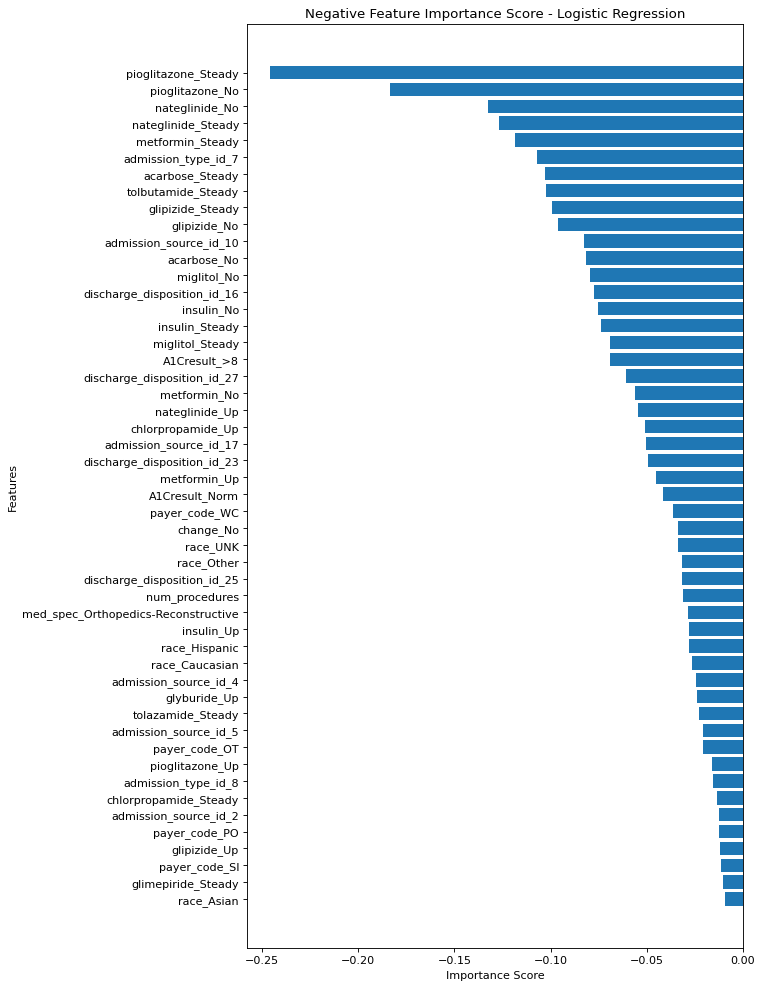

In [136]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

### Feature Importance: random forest

We can also investigate feature importance for random forest models. In this case, the feature importance shows how often a particular feature was used to split the data. In this case, we don't know if a particular feature is correlated with the positive class or negative class, but rather it is just importance for making a decision. 

In [137]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [138]:
feature_importances.head()

,importance
number_inpatient,0.284987
discharge_disposition_id_22,0.076279
number_emergency,0.074264
number_diagnoses,0.059440
num_medications,0.059029


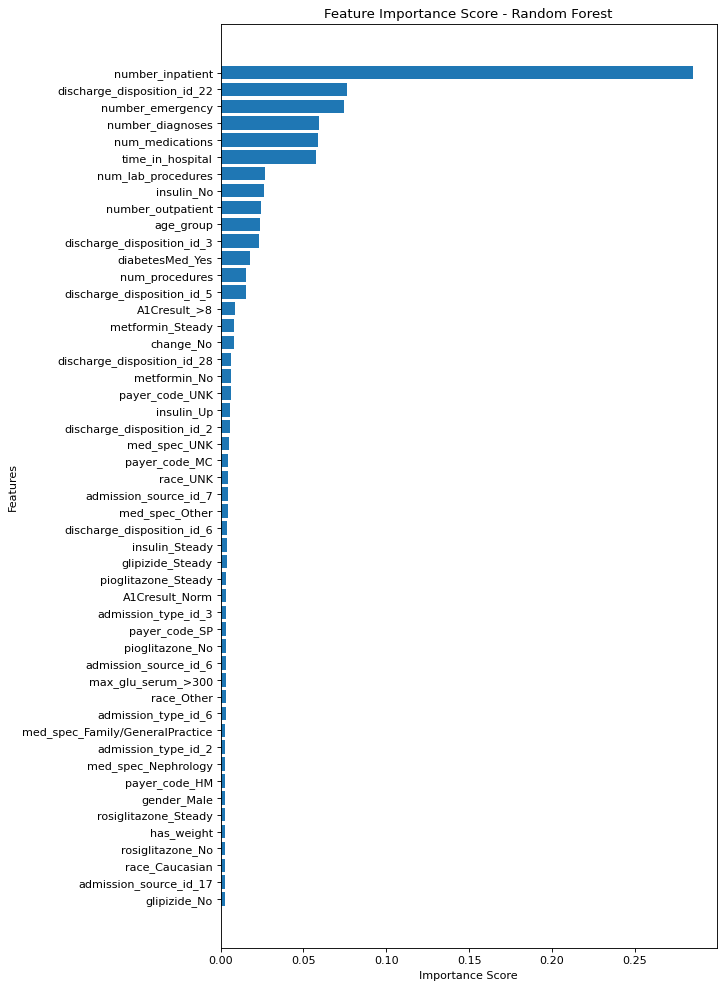

In [139]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

# Model Evaluation

# Conclusion

Through this project, we created a binary classifier to predict the probability that a patient with diabetes would be readmitted to the hospital within 30 days. On held out test data, our best model had an AUC of of 0.67. Using this model, we are able to catch 58% of the readmissions from our model that performs approximately 1.5 times better than randomly selecting patients. 